In [1]:
import os
import numpy as np
import pickle
from nltk.util import bigrams, trigrams
from nltk.lm import MLE, Laplace
from tqdm import tqdm
import torch
from collections import Counter
import math

In [2]:
dataset_root = r'/home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/data'
dataset_name = 'babylm_full_bpe_8k'

data_dir = os.path.join(dataset_root, dataset_name)

train_data = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_data = np.memmap(os.path.join(data_dir, 'val.bin'), dtype=np.uint16, mode='r')


meta_path = os.path.join(data_dir, 'meta.pkl')
meta_vocab_size = None
if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta.get('vocab_size', None)
    if meta_vocab_size:
        print(f"found vocab_size = {meta_vocab_size} (inside {meta_path})")

found vocab_size = 8000 (inside /home/abishekthamma/PycharmProjects/masters_thesis/ss-llm/nanoGPT/data/babylm_full_bpe_8k/meta.pkl)


In [4]:
train_bigrams = bigrams(train_data)
train_bigram_counts = Counter(train_bigrams)
val_bigrams = bigrams(val_data)
val_bigrams_counts = Counter(val_bigrams)
train_trigrams = trigrams(train_data)
train_trigram_counts = Counter(train_trigrams)
val_trigrams = trigrams(val_data)
val_trigrams_counts = Counter(val_trigrams)


KeyboardInterrupt: 

In [74]:
train_bigram_counts.most_common(5)

[((14, 133), 98191),
 ((202, 173), 50943),
 ((12, 207), 45365),
 ((203, 173), 44553),
 ((14, 47), 37822)]

In [3]:
def prepare_bigram_probs(bigrams_counts, vocab_size):
    bigram_arr = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)
    for k,v in bigrams_counts.items():
        bigram_arr[k[1], k[0]] = v

    bigram_prob = (bigram_arr+1).float()
    bigram_probs = bigram_prob /bigram_prob.sum(1, keepdim=True)

    return bigram_probs

def prepare_trigram_probs(trigrams, bigrams, vocab_size):

    trigram_counts = Counter(trigrams)
    bigram_counts = Counter(bigrams)
    trigram_probs = {}

    for k,v in tqdm(trigram_counts.items()):
        trigram_probs[k] = float(v+1)/(bigram_counts[(k[0], k[1])]+vocab_size)

    return trigram_probs



train_bigram_probs = prepare_bigram_probs(train_bigram_counts, meta_vocab_size)
val_bigram_probs = prepare_bigram_probs(val_bigrams_counts, meta_vocab_size)

train_trigram_probs = prepare_trigram_probs(trigrams(train_data), bigrams(train_data), meta_vocab_size)
val_trigram_probs = prepare_trigram_probs(trigrams(val_data), bigrams(val_data), meta_vocab_size)





# train_bigram_arr = torch.zeros((meta_vocab_size, meta_vocab_size), dtype=torch.int32)
# val_bigram_arr = torch.zeros((meta_vocab_size, meta_vocab_size), dtype=torch.int32)
# for k,v in train_bigram_counts.items():
#     train_bigram_arr[k[0], k[1]] = v
# for k,v in val_bigrams_counts.items():
#     val_bigram_arr[k[0], k[1]] = v
# train_bigram_probs = (train_bigram_arr+1).float()
# train_probs = train_bigram_probs /train_bigram_probs.sum(1, keepdim=True)
# val_bigram_probs = (val_bigram_arr+1).float()
# val_probs = val_bigram_probs/val_bigram_probs.sum(1, keepdim=True)

In [4]:
def calculate_bigram_loss(probs, corpus):
    loss = 0
    counts = 0
    for i in tqdm(range(1, len(corpus))):
        loss += -torch.log(probs[corpus[i], corpus[i-1]])
        counts += 1
    return loss/counts

def calculate_trigram_loss(probs, corpus, vocab_size):
    loss = 0
    counts = 0
    for i in tqdm(range(2, len(corpus))):
        trigram_probs = probs.get((corpus[i-2], corpus[i-1], corpus[i]), 1/vocab_size)
        loss += -math.log(trigram_probs)
        counts += 1
    return loss/counts

def calculate_loss(probabilities, corpus, loss_type = 'bigram', vocab_size = None):

    if loss_type == 'bigram':
        return calculate_bigram_loss(probabilities, corpus)
    elif loss_type == 'trigram':
        if not vocab_size:
            raise Exception
        return calculate_trigram_loss(probabilities, corpus, vocab_size)
    else:
        raise ValueError(f"Invalid loss type {loss_type}")


In [78]:
train_bigrams_loss = calculate_loss(train_bigram_probs, train_data, loss_type="bigram")
print(f"bigram_train_loss = {train_bigrams_loss} ")

100%|██████████| 14545184/14545184 [02:32<00:00, 95382.87it/s]

bigram_loss = 5.702608585357666 


In [79]:
val_bigrams_loss = calculate_loss(train_bigram_probs, val_data, loss_type="bigram")
print(f"bigram_val_loss = {val_bigrams_loss} ")

train_trigrams_loss = calculate_loss(train_trigram_probs, train_data, loss_type="trigram", vocab_size=meta_vocab_size)
print(f"trigram train _loss = {train_trigrams_loss} ")

train_bigrams_loss = calculate_loss(train_trigram_probs, val_data, loss_type="trigram", vocab_size=meta_vocab_size)
print(f"trigram_val_loss = {train_bigrams_loss} ")


100%|██████████| 13921893/13921893 [02:27<00:00, 94094.05it/s]


bigram_val_loss = 5.8382182121276855 


100%|██████████| 14545183/14545183 [00:26<00:00, 549868.77it/s]


trigram train _loss = 6.911967814899822 


100%|██████████| 13921892/13921892 [00:25<00:00, 538980.13it/s]

trigram_val_loss = 7.324238471596719 


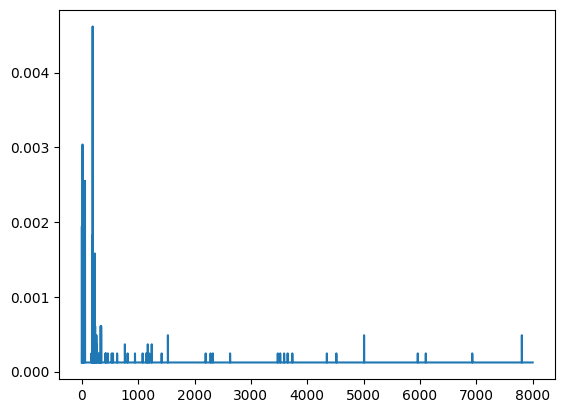

In [6]:
#plot probability distribution of 1 word

import matplotlib.pyplot as plt
plt.plot(train_bigram_probs[7220].numpy())
plt.show()


In [9]:
#convert dataset to list of strings
testing_subset = train_data[:1000]
ts_vocab_size = len(set(testing_subset))

#map values as 0 to vocab_size
itos_mapper = {}
for i in testing_subset:
    itos_mapper[i] = itos_mapper.get(i, len(itos_mapper))

testing_subset = [itos_mapper[i] for i in testing_subset]


ts_bigrams = bigrams(testing_subset)
ts_bigram_counts = Counter(ts_bigrams)
ts_trigrams = trigrams(testing_subset)
ts_trigram_counts = Counter(ts_trigrams)

ts_bigram_probs = prepare_bigram_probs(ts_bigram_counts, ts_vocab_size)
ts_trigram_probs = prepare_trigram_probs(trigrams(testing_subset), bigrams(testing_subset), ts_vocab_size)

ts_bigram_loss = calculate_loss(ts_bigram_probs, testing_subset, loss_type="bigram")
print(f"bigram_test_loss = {ts_bigram_loss} ")

ts_trigram_loss = calculate_loss(ts_trigram_probs, testing_subset, loss_type="trigram", vocab_size=ts_vocab_size)
print(f"trigram_test_loss = {ts_trigram_loss} ")



100%|██████████| 999/999 [00:00<00:00, 65592.42it/s]


bigram_test_loss = 5.205868244171143 


100%|██████████| 998/998 [00:00<00:00, 890620.30it/s]

trigram_test_loss = 5.34031715983772 


In [10]:
testing_subset

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 2,
 21,
 15,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 16,
 31,
 17,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 25,
 39,
 40,
 41,
 42,
 43,
 22,
 44,
 15,
 16,
 45,
 31,
 46,
 47,
 48,
 15,
 22,
 49,
 8,
 16,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 22,
 25,
 58,
 59,
 3,
 60,
 61,
 62,
 63,
 30,
 16,
 17,
 64,
 65,
 66,
 67,
 47,
 25,
 68,
 69,
 70,
 30,
 71,
 3,
 72,
 73,
 22,
 74,
 75,
 8,
 76,
 77,
 15,
 78,
 79,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 69,
 90,
 91,
 92,
 93,
 94,
 69,
 90,
 91,
 92,
 8,
 31,
 95,
 23,
 25,
 88,
 96,
 97,
 69,
 23,
 98,
 99,
 72,
 100,
 94,
 69,
 23,
 13,
 101,
 102,
 15,
 103,
 72,
 23,
 104,
 94,
 105,
 106,
 107,
 98,
 69,
 23,
 108,
 109,
 110,
 111,
 112,
 15,
 113,
 114,
 115,
 116,
 8,
 23,
 117,
 118,
 8,
 72,
 23,
 104,
 118,
 119,
 22,
 23,
 101,
 102,
 15,
 120,
 121,
 122,
 123,
 23,
 94,
 15,
 124,
 23,
 125,
 69,
 126,
 1

In [8]:
#implementing the same but via nltk MLE

testing_subset_str = testing_subset.tolist()
testing_subset_str = [str(i) for i in testing_subset]

print(testing_subset_str[:10])

train_bigram_lm = MLE(2)
train_bigram_lm.fit(bigrams(testing_subset_str), vocabulary_text=meta_vocab_size)
train_bigram_lm.vocab




AttributeError: 'list' object has no attribute 'tolist'

In [6]:
text = [["a", "b", "c", "d"], ["a", "c", "d", "c"]]
from nltk.util import ngrams
text_bigrams = [ngrams(sent, 2) for sent in text]
text_unigrams = [ngrams(sent, 1) for sent in text]

print(list(text_bigrams))
print(list(text_unigrams))

from nltk.lm import NgramCounter
ngram_counts = NgramCounter(text_bigrams + text_unigrams)
print(ngram_counts)

[<zip object at 0x7fee51a343c0>, <zip object at 0x7fee51a3bc00>]
[<zip object at 0x7fee51a3bc80>, <zip object at 0x7fee51a3b900>]
<NgramCounter with 2 ngram orders and 14 ngrams>


In [7]:
from nltk.lm.preprocessing import padded_everygram_pipeline
#train, vocab = padded_everygram_pipeline(2, testing_subset_str)
from nltk.lm.vocabulary import Vocabulary


lm = Laplace(2, vocabulary = Vocabulary(testing_subset_str, unk_cutoff=1)) #, counter=Counter(bigrams(testing_subset_str)))
lm.fit(bigrams(testing_subset_str))

NameError: name 'testing_subset_str' is not defined

In [138]:
lm.score('2')

AttributeError: 'Counter' object has no attribute 'unigrams'

In [135]:
for i,val in enumerate(list(bigrams(testing_subset_str))):
    print(val, lm.score(val[1], val[0]), ts_bigram_probs[itos_mapper[int(val[1])], itos_mapper[int(val[0])]])
    if i > 10:
        break

TypeError: 'int' object is not subscriptable

In [83]:
lm.entropy(list(bigrams(testing_subset_str)))

3.726726889641174

In [7]:
#Loss calculator =


train_bigram_loss = calculate_loss(train_bigram_probs, train_data, 'bigram')
val_bigram_loss = calculate_loss(train_bigram_probs, val_data, 'bigram')


print(f"Train bigram loss = {train_bigram_loss}")
print(f"Val bigram loss = {val_bigram_loss}")



100%|██████████| 13921893/13921893 [02:37<00:00, 88392.45it/s]

Train bigram loss = 5.702608585357666
Val bigram loss = 5.8382182121276855


In [ ]:
testing_subset =

In [8]:
calculate_bigram_loss(train_probs, [1,2,3,4,5,6,7,8,9,10])

100%|██████████| 9/9 [00:00<00:00, 18540.64it/s]


tensor(8.1286)

100%|██████████| 6026069/6026069 [00:06<00:00, 900709.44it/s] 


In [65]:
for i, (k,v) in enumerate(train_trigram_probs.items()):
    if i > 10:
        break
    print(k, v)


(49, 370, 565) 0.00024838549428713363
(370, 565, 39) 0.00024996875390576176
(565, 39, 391) 0.00024909702329057166
(39, 391, 1753) 0.0045871559633027525
(391, 1753, 2315) 0.007099603257465024
(1753, 2315, 3465) 0.0004958472790380563
(2315, 3465, 12) 0.0016223636590540372
(3465, 12, 6812) 0.0003638568829593693
(12, 6812, 9) 0.001120099564405725
(6812, 9, 229) 0.00224271118863693
(9, 229, 267) 0.07475936828333801


In [68]:
#Loss calculator =


train_trigram_loss = calculate_trigram_loss(train_trigram_probs, train_data)
val_trigram_loss = calculate_trigram_loss(train_trigram_probs, val_data)

print(f"Train trigram loss = {train_trigram_loss}")
print(f"Val trigram loss = {val_trigram_loss}")


100%|██████████| 13921892/13921892 [00:25<00:00, 546449.97it/s]

Train trigram loss = 6.911967814899822
Val trigram loss = 7.324238471596719


ValueError: Can't choose from empty population